In [1]:
import os, sys
import numpy as np
import pydicom
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import h5py
import sigpy
from sigpy.mri.samp import poisson
import torch
from torch.fft import ifftn

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.data_io import load_h5, load_output, save_output, \
                            expmt_already_generated
from utils.transform import np_to_tt, split_complex_vals, recon_ksp_to_img, ifft_2d
from utils.helpers import num_params, get_masks
from include.decoder_conv import init_convdecoder
from include.mri_helpers import get_scale_factor, get_masked_measurements, \
                                data_consistency
from include.fit import fit
from utils.evaluate import calc_metrics

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(1)
    
from utils.transform import np_to_tt, np_to_var, ifft_2d, fft_2d, \
                        reshape_complex_channels_to_sep_dimn, \
                        reshape_complex_channels_to_be_adj, \
                        split_complex_vals, recon_ksp_to_img, \
                        fftshift, ifftshift, is_complex, reshape_adj_channels_to_be_complex

In [2]:
path = '/bmrNAS/people/arjun/data/qdess_knee_2020/files_recon_calib-16/'
files = [f for f in listdir(path) if isfile(join(path, f))]
files.sort()

print(len(files))

164


##### data format
- 'kspace': Nx x Ny x Nz x # echos x # coils
- 'maps': Nx x Ny x Nz x # coils x # maps
- 'target': Nx x Ny x Nz x # echos x # maps

take kspace, run on one echo. what to do w num coils? recon all, then rss at end

### load data, make mask

In [3]:
dtype = torch.cuda.FloatTensor

In [4]:
fn = files[0]
f = h5py.File(path + fn, 'r')

# ksp = torch.from_numpy(f['kspace'][()])
# targ = torch.from_numpy(f['target'][()])
ksp = torch.from_numpy(np.load('ksp_3d_samp.npy'))

# get echo1, reshape to be (nc, kx, ky, kz)
ksp_vol = ksp[:,:,:,0,:].permute(3,0,1,2)
ksp_vol.shape

torch.Size([16, 512, 512, 160])

In [5]:
# mask = poisson(img_shape=(512, 160), accel=4)
# mask = abs(mask)
# np.save('mask_3d.npy', mask)
mask = torch.from_numpy(np.load('mask_3d.npy').astype('float32'))
mask.shape

torch.Size([512, 160])

### get central slice in kx of volumes
because dd+ requires a 2d recon, and we're undersampling in ky, kz

In [6]:
idx_kx = ksp_vol.shape[1] // 2
ksp_orig = ksp_vol[:, idx_kx, :, :]

### initialize network

network has same num_params as original network w lone difference of 32 = 2 * n_c output channels instead of 30. hence as written now, network is agnostic to number of pixels in a slice, e.g. 512x512 would have same num_params as 512x160 -- is this right?

In [7]:
# slice_ksp (nc, x, y) in original. now slice_ksp (nc, y, z)
# mask is mask2d is (x,y) in original. now (y,z)
net, net_input, ksp_orig = init_convdecoder(ksp_orig, mask)

# from utils.helpers import num_params
# params = [p.shape for p in net.parameters()]
# params

### apply mask
currently a modified version of the function call `ksp_masked, img_masked = get_masked_measurements(vol_ksp, mask_)` which has a bunch of data shape conversion nonsense

In [8]:
ksp_masked = ksp_orig * mask
img_masked = ifft_2d(ksp_masked)

ksp_orig.shape, ksp_masked.shape, img_masked.shape

(torch.Size([16, 512, 160]),
 torch.Size([16, 512, 160]),
 torch.Size([16, 512, 160]))

### TODO: make new data format work for fastmri
    
### do all array processing in torch!

### run network

In [11]:
# want img_masked, ksp_masked to be complex tensors shape [nc,x,y]
net, mse_wrt_ksp, mse_wrt_img = fit(
        ksp_masked=ksp_masked, img_masked=img_masked,
        net=net, net_input=net_input, mask2d=mask, num_iter=10)

In [13]:
def root_sum_squares(arr):
    ''' given 3d complex arr [nc,x,y], perform rss over magnitudes 
        return 2d arr [x,y] '''
    
    assert is_complex(arr)
    return torch.sqrt(torch.sum(torch.square(abs(arr)), axis=0))

def plot_single(arr):
    plt.figure(figsize=(10, 10))
    plt.imshow(arr.detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

# FIX

- something weird going on w the scaling
- when i make ksp_dc with...
    - ksp_orig (scaled by initcd()), output looks bad
    - ksp_slice (not scaled), output looks decent
- when i make ksp_est with...
    - ksp_orig (scaled), output looks shit just like ksp_dc
    - ksp_slice (not scaled), output looks decent... but still ksp_dc looks bad
    
# TODO: seeing a 

In [14]:
ksp_slice = torch.from_numpy(np.load('ksp_slice_ie_nonscaled.npy'))
tt = abs(ksp_slice - ksp_orig)
tt.max()

tensor(2.3441e+08)

In [18]:
img_out = net(net_input.type(dtype))[0]

# make complex tensor [nc,x,y] from [2*nc,x,y]
img_out = reshape_adj_channels_to_be_complex(img_out)

ksp_est = fft_2d(img_out)

# apply dc step using 3d boolean mask
mask_3d_bool = mask.expand(16, 512, 160).type(torch.bool)
ksp_dc = torch.where(mask_3d_bool, ksp_slice, ksp_est) # arg 2 either ksp_slice (non-scaled) or ksp_orig (scaled)

abs(ksp_slice).max(), abs(ksp_orig).max(), abs(ksp_est).max()

(tensor(2.3443e+08),
 tensor(22578.9805),
 tensor(49189.9062, grad_fn=<MaxBackward1>))

In [19]:
img_est = root_sum_squares(ifft_2d(ksp_est))

img_dc = root_sum_squares(ifft_2d(ksp_dc))

img_gt = root_sum_squares(ifft_2d(ksp_orig))

### issue

- network recon is trash, i.e. doesn't converge to anything
- other processing seems to work, e.g.
    - plotting images
    - performing ifft on k-space or masked k-space
   

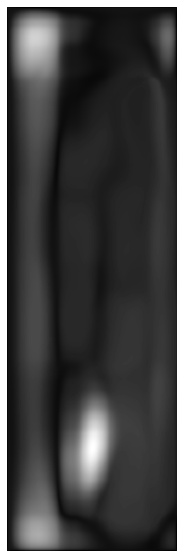

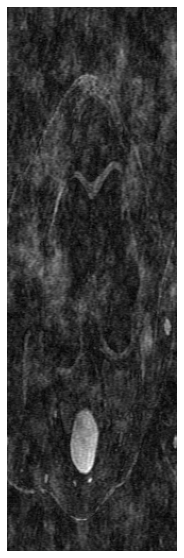

In [21]:
plot_single(img_est)
plot_single(img_dc)

In [ ]:
sys.exit()

In [ ]:
o = torch.arange(9).reshape(3,3)
m = torch.tensor([[0,0,1],[0,1,0],[1,1,0]])
e = torch.arange(10,19).reshape(3,3)


o, m, e

In [ ]:
m = m.type(torch.bool)

In [ ]:
torch.where(m, o, e)